In [85]:
## packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import cufflinks as cf
from ipywidgets import interact
from scipy.stats import norm

In [2]:
raw_data = pd.read_csv('/Users/rahuldhakecha/coursesfall2017/goodreads/files/top_2000_user_perspective/unscrape_books/users_2000_book_details.csv', dtype={'rating':np.float64})
# remove all entries which have no genre mentioned, this essentially removes all other NaNs also. In total, we have 199 rows removed
raw_data=raw_data[-raw_data['genre'].isnull()]
## split different genres into different columsn
def get_genre(x, n):
    try:
        return x.split(';')[n-1].lstrip()
    except (AttributeError,TypeError,IndexError):
        return x.split(';')[0].lstrip()
raw_data['genre1']=raw_data['genre'].apply(get_genre,args=[1])
raw_data['genre2']=raw_data['genre'].apply(get_genre,args=[2])
raw_data['genre3']=raw_data['genre'].apply(get_genre,args=[3])
raw_data['genre4']=raw_data['genre'].apply(get_genre,args=[4])
raw_data['genre5']=raw_data['genre'].apply(get_genre,args=[5])
raw_data['genre6']=raw_data['genre'].apply(get_genre,args=[6])

/Users/rahuldhakecha/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
# pd.options.display.max_rows = 4000
old_new_genres=pd.read_csv('/Users/rahuldhakecha/coursesfall2017/goodreads/files/top_2000_user_perspective/unique_genres_reduced_set_JE.csv')
old_new_genres=old_new_genres.drop_duplicates()
#replace with new genre categorizatoion
raw_data=raw_data.join(old_new_genres.set_index('Old_genre'),on='genre1')
# del raw_data['genre1']
raw_data=raw_data.rename(columns={'New_genre':'New_genre1'})
raw_data=raw_data.join(old_new_genres.set_index('Old_genre'),on='genre2')
# del raw_data['genre2']
raw_data=raw_data.rename(columns={'New_genre':'New_genre2'})
raw_data=raw_data.join(old_new_genres.set_index('Old_genre'),on='genre3')
# del raw_data['genre3']
raw_data=raw_data.rename(columns={'New_genre':'New_genre3'})
raw_data=raw_data.join(old_new_genres.set_index('Old_genre'),on='genre4')
# del raw_data['genre4']
raw_data=raw_data.rename(columns={'New_genre':'New_genre4'})
raw_data=raw_data.join(old_new_genres.set_index('Old_genre'),on='genre5')
# del raw_data['genre5']
raw_data=raw_data.rename(columns={'New_genre':'New_genre5'})
raw_data=raw_data.join(old_new_genres.set_index('Old_genre'),on='genre6')
# del raw_data['genre6']
raw_data=raw_data.rename(columns={'New_genre':'New_genre6'})

In [4]:
#Fiction doesn't carry much information; therefore we remove it and replace it with next different categorization
def replace_fiction(x):
    try:
        i=0
        while x[i]=='Fiction':
            i+=1
        return x[i]
    except IndexError:
        return x[0]
data_wo_fiction=raw_data
data_wo_fiction['New_genre']=raw_data[['New_genre1','New_genre2','New_genre3','New_genre4','New_genre5','New_genre6']].apply(replace_fiction,axis=1)

In [5]:
## for our initial analysis we focus on user_id, book_id and New_genre
# our data is categorical and therefore we begin with categorical analysis. 
pre_data=data_wo_fiction[['user_id','book_id','New_genre']]
pre_data = pre_data[pre_data['New_genre']!='Fiction']
unique_books=(pre_data[['book_id','New_genre']]).drop_duplicates()
genre_dist=unique_books.groupby('New_genre').agg('count').reset_index().rename(columns={'book_id':'book_count'})
genre_dist['percent_book_count']=(genre_dist['book_count']*100)/sum(genre_dist['book_count'])

In [6]:
# we can find cross table for user and genres
user_genre_cross=pd.crosstab(pre_data['user_id'],pre_data['New_genre'])

In [7]:
#determine primary genre for each user based on the count; if primary genre is Nonfiction, then go to next genre
df1_temp=user_genre_cross.idxmax(axis=1).to_frame().reset_index().rename(columns={0:'Genre'})
df2_temp=user_genre_cross.max(axis=1).to_frame().reset_index().rename(columns={0:'Genre_count'})
user_prim_genre=df1_temp.merge(df2_temp)
def replace_nonfiction(x):
    try:
        if user_genre_cross.loc[x[0]].sort_values(ascending=False).to_frame().reset_index()['New_genre'][0]=='Nonfiction':
            return(user_genre_cross.loc[x[0]].sort_values(ascending=False).to_frame().reset_index()['New_genre'][1])
        else:
            return(x[1])
    except:
        return(x[1])
user_prim_genre['New_genre']=user_prim_genre[['user_id','Genre']].apply(replace_nonfiction,axis=1)
user_genre_dist=user_prim_genre.groupby('New_genre').agg('count').reset_index()
user_prim_genre=user_prim_genre.set_index('user_id')[['New_genre']]

In [8]:
user_cross_prim = user_genre_cross.join(user_prim_genre)

In [102]:
user_cross_prim.drop(['Nonfiction'],axis=1)

New_genre,Childrens,Christian Fiction,Erotic Fiction,Fantasy,Graphic Novels,Historical Fiction,Horror Suspense,Literary Fiction,Mystery Crime Detective,Queer Fiction,Romance,Science Fiction,Thriller,Westerns,Womens Fiction,YA,New_genre,primary_prop
user_id,,,,,,,,,,,,,,,,,,
5231,65,0,6,9,9,45,4,66,15,13,5,4,0,0,31,25,Literary Fiction,0.130178
13699,7,0,2,6,28,29,1,180,6,0,4,7,0,1,1,14,Literary Fiction,0.334572
15411,0,0,2,193,0,89,11,3,358,0,157,13,4,0,45,91,Mystery Crime Detective,0.365679
21659,27,0,12,125,49,59,4,59,17,1,86,54,2,0,5,56,Fantasy,0.202922
27435,1,0,13,11,0,71,9,53,71,2,24,15,6,0,114,40,Womens Fiction,0.161932
27539,12,0,1,45,40,30,2,26,17,2,6,11,1,0,0,72,YA,0.236842
31186,1,0,1,27,36,12,2,9,5,0,1,50,0,0,1,9,Science Fiction,0.252525
31879,8,0,1,80,2,10,11,77,8,1,0,36,1,1,0,9,Fantasy,0.251572
32014,2,1,0,33,3,50,2,24,64,0,6,2,0,0,18,10,Mystery Crime Detective,0.226148


In [103]:
def find_prop(x):
    a=1.0 * user_genre_cross.loc[x[0]][x[1]]
    b=1.0 * sum(user_genre_cross.loc[x[0]])
    return(a/b)
user_cross_prim['primary_prop']=list(user_cross_prim.reset_index()[['user_id','New_genre']].apply(find_prop,axis=1))

In [112]:
# Hypthesis testing:
# H0: People with primary genre of romance, tend to read less than or equal to 50% of books of romance
# H1: People with primary genre of romance, tend to read more than 50% of books of romance

# test statistics: we count mean proportion for all users with Romance as their primary genre
def hypo_test(x):
    mean_readings=user_cross_prim[user_cross_prim['New_genre']==x]['primary_prop'].mean()
    std_readings=user_cross_prim[user_cross_prim['New_genre']==x]['primary_prop'].std()
    z_val=(1.0*(mean_readings-0.20))/std_readings
    return(1-norm.cdf(z_val))
interact(hypo_test, x=list(user_cross_prim['New_genre'].unique()))

nan

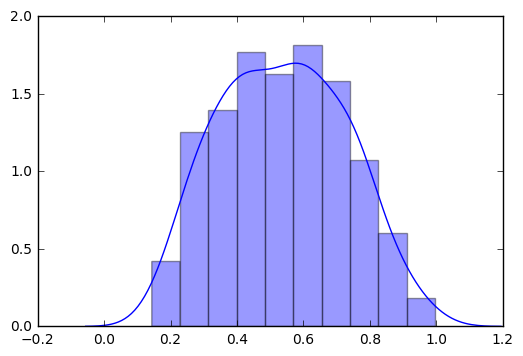

In [83]:
sns.distplot(list(user_cross_prim[user_cross_prim['New_genre']=='Romance']['primary_prop']))
plt.show()

In [111]:
user_cross_prim[user_cross_prim['New_genre']=='Erotic Fiction']['primary_prop'].std()

0.004314965644263234

In [114]:
## Bokeh interface
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [115]:
from bokeh.io import show
from bokeh.plotting import figure

In [116]:
p=figure()
p.circle(x=user_cross_prim['Mystery Crime Detective'], y=user_cross_prim['Thriller'])
show(p)